<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - Classifying Grab's Customer Feedback into Ride Hailing and Delivery

> Authors: Irfan Muzafar, Ng Wei, Lim Zheng Gang
---

**Problem Statement:**  
How can we distinguish between customer feedback related to Grab's ride-hailing and delivery fast and accurately? 

**Target Audience:**
- Grab Product Team

**Summary:**   
- Product Manager is overwhelmed by vast user reviews; struggles to classify reviews between delivery and ride hailing.
- Develop a NLP model to differentiate ride-hailing comments from delivery on Grab's Google Play Store.
- Training data: Uber and Uber Eats subreddit.
- Other data sources: App store reviews from Grab and Grab Driver applications as well as those from competitors:  
  - foodpanda  
  - Deliveroo  
  - Gojek  

There are a total of three notebooks for this project:  
 1. `01_Data_Collection.ipynb`   
 2. `02_Data_Cleaning_EDA.ipynb`   
 3. `03_Modelling_Evaluation_Conclusion.ipynb`   

---
**This Notebook**  
  
We will 
- Fit our data into various models and evaluate the performance of each model. 
- Select our preferred model.
- Evaluate our selected model.
- Test classifer on the actual Grab app store reviews. 
- Conclusion and recommendation

### 1. Import Libraries, read CSV

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from scipy.stats import randint
from IPython.display import Image
from joblib import dump



In [2]:
df = pd.read_csv("../datasets/cleaned_data.csv")

In [3]:
df.head()

,body,ubereats
0,would you let this woman in your car for an ub...,0
1,a raccoon with a big shirt on ? i don ’ t see ...,0
2,hell yeah . love those little critter . had on...,0
3,i mean the biggie shirt sell it for me . i nev...,0
4,"well , he/she do have a shirt on .",0


### 2. Modelling

#### Success Metric

Our classifier is designed to categorize reviews across different types of services, where both false positives and false negatives are considered equally detrimental. Therefore, we have selected accuracy as the primary metric to optimize in our model. We will also take computational intensiveness of a model into consideration in the event of two models having an effective accuracy score. 

We define the below function for the generation of classification metrics in this notebook.

In [4]:
def calculate_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return sensitivity, specificity, precision, accuracy

We've selected three classifiers for evaluation:

- Multinomial Naive Bayes  
- K Nearest Neighbor Classifier
- Logistic Regression  

For each classifier, we'll preprocess our training data using both the Count Vectorizer and TF-IDF Vectorizer to determine which model yields the best performance. Furthermore, to assess the effectiveness of hyperparameter tuning, we'll initially run each model with default settings to establish a baseline, allowing us to measure the tuning's impact.

The below concepts are used throughout all three model.

**1. CountVectorizer**  
CountVectorizer transforms text into a frequency count vector, creating a matrix where each unique word is a feature and counts represent their occurrences in documents. We use it to preprocess our data before fitting it into the respective models.

**2. TF-IDF Vectorizer**  
TF-IDF Vectorizer measures word importance by considering their frequency in a document relative to their frequency across all documents, helping differentiate meaningful words. We use it to preprocess our data before fitting it into the respective models.

**3. Pipeline**  
A Pipeline streamlines the process of applying a series of data transformations followed by the application of a model, ensuring consistency in data handling.

**4. Cross Validation**  
Cross Validation evaluates a model’s performance by dividing the dataset into several subsets, training on some and testing on others, to ensure the model's generalizability. We use cv=5 throughout this project. 

#### 2.1. Train-Test Split and Baseline Model

##### 2.1.1. Train-Test Split

Splits the dataset into training and testing sets for a classification task. It selects the "body" column as the feature variable and the "ubereats" column as the target variable. With a test size of 25%, it ensures class distribution balance using stratify. Setting a random state ensures reproducibility. This process readies the data for training and evaluating a classification model.

In [5]:
X = df["body"]
y = df["ubereats"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

##### 2.1.2. Baseline Model

Assuming a basic model that only predicts the most common class, we define this approach as our baseline accuracy for the classifier. This simplistic method sets a minimum performance threshold, against which we'll compare more complex models.

In [6]:
y_test.value_counts(normalize=True)

ubereats
1    0.523674
0    0.476326
Name: proportion, dtype: float64

Given the approach of predicting the most common class, our baseline model achieves an accuracy of 52%. This figure serves as the initial performance benchmark for our classifier.

#### 2.2. Multinomial Naive Bayes


Multinomial Naive Bayes calculates the probability of each category based on the frequency of words present in the text. It is particularly suited for discrete features like word counts or frequencies in document classification tasks. The Multinomial Naive Bayes model is chosen over the Bernoulli and Gaussian variants because it handles discrete count data effectively.

##### 2.2.1 Pipeline: Countvectorizer and Multinomial Naive Bayes

Without hypertuning as baseline for Countvectorizer and Multinomial Naive Bayes model

In [7]:
# pipeline creation

pipe_cvnb_base = Pipeline([
    ('cvec', CountVectorizer(stop_words = "english")),
    ('nb', MultinomialNB())
])

# fit training data to pipeline

pipe_cvnb_base.fit(X_train, y_train)

# print train score and test score. The score printed here is the accuracy score

print(f"train score: {pipe_cvnb_base.score(X_train, y_train)}")
print(f"test score: {pipe_cvnb_base.score(X_test, y_test)}")

train score: 0.8110326549180166
test score: 0.7678295953482853


The Count Vectorizer Multinomial Naive Bayes model, prior to hyperparameter tuning, achieves a training score of 0.81 and a testing score of 0.76. These results will serve as the baseline for comparing the performance of the model after hyperparameter tuning.

Countvectorizer Multinomial Naive Bayes Model with hypertuning. We use gridsearch to search for the best parameters that give us the best performing model.

In [8]:
# pipeline creation

pipe_cvnb_gridsearch = Pipeline([
    ('cvec', CountVectorizer(stop_words = "english")),
    ('nb', MultinomialNB())
])

# define params for gridsearch and search for the best params

pipe_cvnb_gridsearch_params = {
    'cvec__max_features': [4000,5000,6000, None],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.85,0.9],
    'cvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [0.1, 0.5, 1]
}

cvnb_gridsearch = GridSearchCV(pipe_cvnb_gridsearch, 
                  param_grid=pipe_cvnb_gridsearch_params, 
                  cv=5)

# fit training data in model

cvnb_gridsearch.fit(X_train, y_train)

print(f"best param: {cvnb_gridsearch.best_params_}")
print(f"best score: {cvnb_gridsearch.best_score_}")
print(f"train score: {cvnb_gridsearch.score(X_train, y_train)}")
print(f"test score: {cvnb_gridsearch.score(X_test, y_test)}")

best param: {'cvec__max_df': 0.85, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'nb__alpha': 1}
best score: 0.7691806705067422
train score: 0.8562075990427026
test score: 0.7766108935564258


Generate confusion matrix and classification evaluation metrics

Sensitivity (True Positive Rate): 0.8183775209607976
Specificity (True Negative Rate): 0.7306925759840558
Precision: 0.7696323921150773
Accuracy: 0.7766108935564258


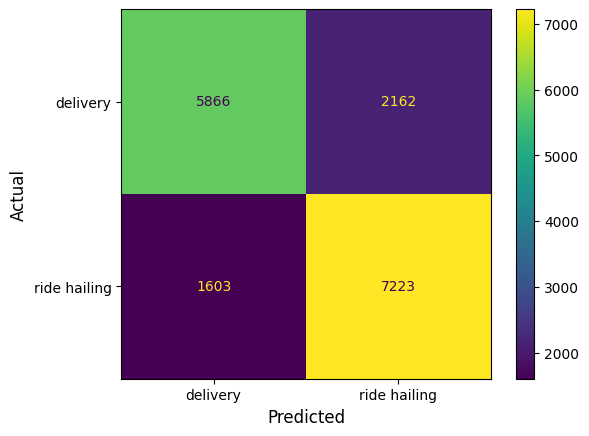

In [9]:

class_names = ['delivery', 'ride hailing'] 
preds = cvnb_gridsearch.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

cm = confusion_matrix(y_test, preds)

disp =ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=class_names )

ax = disp.plot().ax_

ax.set_ylabel('Actual', fontsize=12)
ax.set_xlabel('Predicted', fontsize=12)

sensitivity, specificity, precision, accuracy = calculate_metrics(cm)

print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)
print("Precision:", precision)
print("Accuracy:", accuracy)

The model has training and test scores of 85.6% and 77.7%, respectively, indicating mild overfitting. High sensitivity (81.8%) and reasonable precision (76.9%) highlight its strength in identifying positives, though lower specificity (73.1%) suggests a need for better recognition of negatives. Overall accuracy stands at 77.7%.

Comparing the hypertuned model with its counterpart before tuning, we see an improvement of train score of 4% and improvement of test score of 1%. 

##### 2.2.2 Pipeline: TF-IDF Vectorizer and Multinomial Naive Bayes

Without hypertuning as baseline for TF-IDF and Multinomial Naive Bayes model

In [10]:
pipe_tvnb_base = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = "english")),
    ('nb', MultinomialNB())
])

pipe_tvnb_base.fit(X_train, y_train)

print(f"train score: {pipe_tvnb_base.score(X_train, y_train)}")
print(f"test score: {pipe_tvnb_base.score(X_test, y_test)}")

train score: 0.8222274965881445
test score: 0.7666429334282663


The TF-IDF Vectorizer Multinomial Naive Bayes model, prior to hyperparameter tuning, achieves a training score of 0.82 and a testing score of 0.77. These results will serve as the baseline for comparing the performance of the model after hyperparameter tuning.

TF-IDF Multinomial Naive Bayes Model with hypertuning. We use gridsearch to search for the best parameters that give us the best performing model.

In [11]:
pipe_tvnb_gridsearch = Pipeline([
    ('tvnb', TfidfVectorizer(stop_words = "english")),
    ('nb', MultinomialNB())
])

pipe_tvnb_gridsearch_params = {
    'tvnb__max_features': [2_000, 3_000, 4_000, 5_000, None],
    'tvnb__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [0.1, 0.5, 1]
}

tvnb_gridsearch = GridSearchCV(pipe_tvnb_gridsearch,
                        param_grid = pipe_tvnb_gridsearch_params,
                        cv=5) 

tvnb_gridsearch.fit(X_train, y_train)

print(f"best param: {tvnb_gridsearch.best_params_}")
print(f"best score: {tvnb_gridsearch.best_score_}")
print(f"train score: {tvnb_gridsearch.score(X_train, y_train)}")
print(f"test score: {tvnb_gridsearch.score(X_test, y_test)}")

best param: {'nb__alpha': 1, 'tvnb__max_features': None, 'tvnb__ngram_range': (1, 2)}
best score: 0.7734132947854762
train score: 0.9438477817994818
test score: 0.781060875756497


Generate confusion matrix and classification evaluation metrics

Sensitivity (True Positive Rate): 0.8191706322229776
Specificity (True Negative Rate): 0.7391629297458894
Precision: 0.7754182754182755
Accuracy: 0.781060875756497


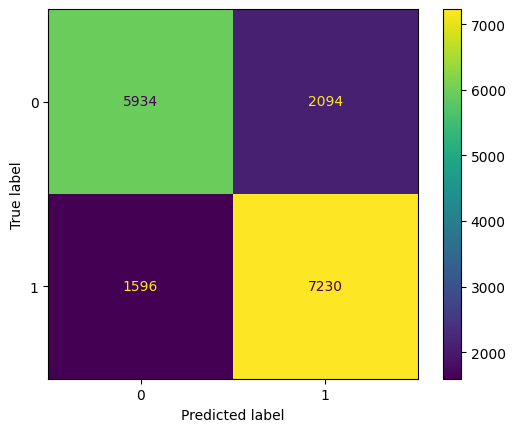

In [12]:
preds = tvnb_gridsearch.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

cm = confusion_matrix(y_test, preds)

disp =ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=tvnb_gridsearch.best_estimator_.classes_)
disp.plot()

sensitivity, specificity, precision, accuracy = calculate_metrics(cm)

print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)
print("Precision:", precision)
print("Accuracy:", accuracy)



The model's high training score (94.3%) versus its test score (78.1%) suggests overfitting, as it performs less effectively on unseen data. Despite good sensitivity (81.9%) and precision (77.5%), its relatively lower specificity (73.9%) indicates room for improvement in identifying true negatives.

Comparing the hypertuned model with its counterpart before tuning, we see an improvement of train score of 12% and improvement of test score of 2%. However, due to the severe signs of overfitting of this model. We will not consider this model especially since we expect our use case to deal with unseen data. We will reiterate this point again when we are doing evaluation.

#### 2.3. KNeighbours Classifier


K-Nearest Neighbors (KNN) is a instance-based algorithm where the class of a sample is determined by the majority class among its k nearest neighbors in the feature space. It is versatile, used for both classification and regression tasks, but sensitive to the scale of the data and the choice of k.

##### 2.3.1 Pipeline: TF-IDF Vectorize and KNeighbours Classifier

Baseline for model without hypertuning

In [13]:
pipe_tvkn_base = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = "english")),
    ('kn', KNeighborsClassifier())
])

pipe_tvkn_base.fit(X_train, y_train)

print(f"train score: {pipe_tvkn_base.score(X_train, y_train)}")
print(f"test score: {pipe_tvkn_base.score(X_test, y_test)}")

#average run time : 2 mins 

train score: 0.7266362072034652
test score: 0.5595110952889522


The TF-IDF Vectorizer KNeighbours model, prior to hyperparameter tuning, achieves a training score of 0.72 and a testing score of 0.55. These results will serve as the baseline for comparing the performance of the model after hyperparameter tuning.

Model with hypertuning. We use gridsearch to search for the best parameters that give us the best performing model.

In [14]:
pipe_tvkn_gridsearch = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = "english")),
    ('kn', KNeighborsClassifier())
])

pipe_tvkn_gridsearch_params = {
    'tvec__max_features': [1000, 3_000, 5_000, None],
    'tvec__ngram_range': [(1,1), (1,2)],
    'kn__n_neighbors': [31,41,51], # select an odd number to prevent ties
    'kn__weights': ["distance","uniform"],
    'kn__p': [1,2]

}

tvkn_gridsearch = GridSearchCV(pipe_tvkn_gridsearch,
                  param_grid=pipe_tvkn_gridsearch_params,
                  cv=5)

tvkn_gridsearch.fit(X_train, y_train)

print(f"best param: {tvkn_gridsearch.best_params_}")
print(f"best score: {tvkn_gridsearch.best_score_}")
print(f"train score: {tvkn_gridsearch.score(X_train, y_train)}")
print(f"test score: {tvkn_gridsearch.score(X_test, y_test)}")

#average run time : 20 mins 

best param: {'kn__n_neighbors': 31, 'kn__p': 2, 'kn__weights': 'uniform', 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 2)}
best score: 0.5734884768781713
train score: 0.6121758737316798
test score: 0.5757090304972113


Generate confusion matrix and classification evaluation metrics

Sensitivity (True Positive Rate): 0.8642646725583504
Specificity (True Negative Rate): 0.2584703537618336
Precision: 0.5616670348280687
Accuracy: 0.5757090304972113


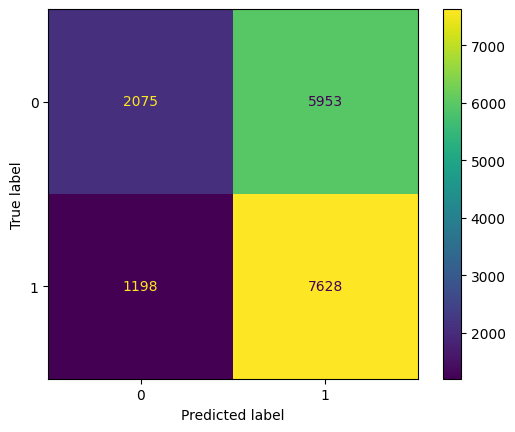

In [15]:
preds = tvkn_gridsearch.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

cm = confusion_matrix(y_test, preds)

disp =ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=tvkn_gridsearch.best_estimator_.classes_)
disp.plot()

sensitivity, specificity, precision, accuracy = calculate_metrics(cm)

print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)
print("Precision:", precision)
print("Accuracy:", accuracy)

With a training accuracy of 61.2% and a testing accuracy of 57.6%, the model exhibits a slight overfitting, indicating a diminished ability to generalize to unseen data. The high sensitivity of 86.4% underscores the model's proficiency in identifying true positives, while the notably low specificity of 25.8% and modest precision of 56.2% reveal difficulties in accurately recognizing true negatives and a substantial rate of false positives.

The overall accuracy standing at 57.6% suggests limited utility in practical applications, highlighting the necessity for modifications to the model to enhance its generalization capabilities and specificity.

Despite the challenges presented by the current model's performance, the insights derived from these metrics serve as a critical guide for future adjustments and iterations to improve its effectiveness in real-world settings.

Comparing the hypertuned model with its counterpart before tuning, we do not see an improvement in train score but an improvement in test score of 1%. We will compare the accuracy of this model with the rest in the evaluation section to determine the best model. 

##### 2.3.2 Pipeline: CountVectorizer and KNeighbours Classifier

Baseline for model without hypertuning

In [16]:
pipe_cvkn_base = Pipeline([
    ('cvec', CountVectorizer(stop_words = "english")),
    ('kn', KNeighborsClassifier())
])

pipe_cvkn_base.fit(X_train, y_train)

print(f"train score: {pipe_cvkn_base.score(X_train, y_train)}")
print(f"test score: {pipe_cvkn_base.score(X_test, y_test)}")

train score: 0.7740857216321525
test score: 0.6465527471223449


The Count Vectorizer KNeighbours model, prior to hyperparameter tuning, achieves a training score of 77% and a testing score of 64%. These results will serve as the baseline for comparing the performance of the model after hyperparameter tuning.

Model with hypertuning. We use gridsearch to search for the best parameters that give us the best performing model.

In [17]:
pipe_cvkn_gridsearch = Pipeline([
    ('cvec', CountVectorizer(stop_words = "english")),
    ('kn', KNeighborsClassifier())
])

pipe_cvkn_gridsearch_params = {
    'cvec__max_features': [1000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.85,0.9],
    'cvec__ngram_range': [(1,1), (1,2)],
    'kn__n_neighbors': [31,51], # select an odd number to prevent ties
    'kn__weights': ["uniform"],
    'kn__p': [1,2]
}

cvkn_gridsearch = GridSearchCV(pipe_cvkn_gridsearch,
                  param_grid=pipe_cvkn_gridsearch_params,
                  cv=5)

cvkn_gridsearch.fit(X_train, y_train)

print(f"best param: {cvkn_gridsearch.best_params_}")
print(f"best score: {cvkn_gridsearch.best_score_}")
print(f"train score: {cvkn_gridsearch.score(X_train, y_train)}")
print(f"test score: {cvkn_gridsearch.score(X_test, y_test)}")

#average run time : 24 mins 

best param: {'cvec__max_df': 0.85, 'cvec__max_features': 1000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'kn__n_neighbors': 31, 'kn__p': 2, 'kn__weights': 'uniform'}
best score: 0.6607922256778868
train score: 0.6912715836942978
test score: 0.6709386495787351


Generate confusion matrix and classification evaluation metrics

Sensitivity (True Positive Rate): 0.8746884205755722
Specificity (True Negative Rate): 0.4469357249626308
Precision: 0.6348684210526315
Accuracy: 0.6709386495787351


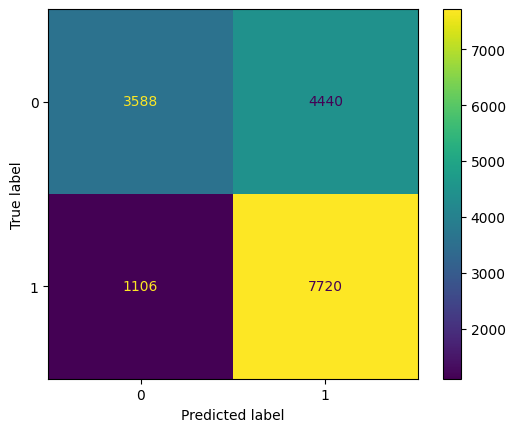

In [18]:
preds = cvkn_gridsearch.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

cm = confusion_matrix(y_test, preds)

disp =ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=cvkn_gridsearch.best_estimator_.classes_)
disp.plot()

sensitivity, specificity, precision, accuracy = calculate_metrics(cm)

print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)
print("Precision:", precision)
print("Accuracy:", accuracy)

The model, showing overfitting with a training score of 69.1% and test score of 67.1%, is effective at identifying positives (sensitivity 87.5%) but struggles with true negatives (specificity 44.7%). Precision at 63.4% and accuracy at 67.1% indicate moderate effectiveness, highlighting areas for improvement in generalization and specificity. Due to the severe signs of overfitting shown, we will not consider this model. 

Comparing to the baseline model, the test score improved by approx 3%. 

#### 2.4. Logistics Regression

Logistic Regression is a statistical method for predicting binary outcomes by using a logistic function to model the probability of a default class, based on one or more independent variables. It is widely used for classification tasks, particularly when there is a need to estimate the probability of an event occurrence.

##### 2.4.1 Pipeline: TF-IDF Vectorizer and Logistics Regression

Baseline model without hypertuning

In [19]:
pipe_tvlr_base = Pipeline([
     ('tvec', TfidfVectorizer(stop_words = "english")),
    ('lr', LogisticRegression())
])

pipe_tvlr_base.fit(X_train, y_train)

print(f"train score: {pipe_tvlr_base.score(X_train, y_train)}")
print(f"test score: {pipe_tvlr_base.score(X_test, y_test)}")


train score: 0.8195375699677604
test score: 0.7687195917882995


The TF_IDF Logistic Regression model, prior to hyperparameter tuning, achieves a training score of 81.9% and a testing score of 76.8%. These results will serve as the baseline for comparing the performance of the model after hyperparameter tuning.

Model with hypertuning. We use gridsearch to search for the best parameters that give us the best performing model.

In [20]:
pipe_tvlr_gridsearch = Pipeline([
     ('tvec', TfidfVectorizer(stop_words = "english")),
    ('lr', LogisticRegression())
])

pipe_tvlr_gridsearch_params = {
    'lr__C': [0.1, 0.5, 1],  
    'lr__max_iter': [100,150],
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000, None],
    'tvec__ngram_range': [(1,1), (1,2)]
}

tvlr_gridsearch = GridSearchCV(pipe_tvlr_gridsearch, 
                  param_grid=pipe_tvlr_gridsearch_params, 
                  cv=5)


tvlr_gridsearch.fit(X_train, y_train)

print(f"best param: {tvlr_gridsearch.best_params_}")
print(f"best score: {tvlr_gridsearch.best_score_}")
print(f"train score: {tvlr_gridsearch.score(X_train, y_train)}")
print(f"test score: {tvlr_gridsearch.score(X_test, y_test)}")

# run time: 12 mins

best param: {'lr__C': 1, 'lr__max_iter': 100, 'tvec__max_features': None, 'tvec__ngram_range': (1, 2)}
best score: 0.7649677132093259
train score: 0.8912755394687395
test score: 0.7719829120683517


Generate confusion matrix and classification evaluation metrics

Sensitivity (True Positive Rate): 0.8195105370496261
Specificity (True Negative Rate): 0.7197309417040358
Precision: 0.762733312242961
Accuracy: 0.7719829120683517


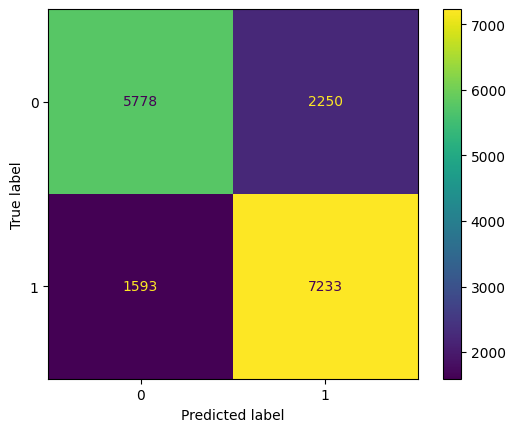

In [21]:
preds = tvlr_gridsearch.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

cm = confusion_matrix(y_test, preds)

disp =ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=tvlr_gridsearch.best_estimator_.classes_)
disp.plot()

sensitivity, specificity, precision, accuracy = calculate_metrics(cm)

print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)
print("Precision:", precision)
print("Accuracy:", accuracy)

The model has training (89.1%) and test (77.1%) scores, suggesting moderate generalization. With sensitivity at 81.9% and specificity at 72%, it's effective at identifying both positives and negatives. Precision at 76.3% and overall accuracy at 77.1% indicate a strong performance, though there's room for improvement in precision and specificity. 

Comparing to the baseline model, the test score improves by less than 1%. We will evaluate this model with the rest of the models in the evaluation section. 

##### 2.4.2 Pipeline: CountVectorizer and Logistics Regression

Baseline model without hypertuning

In [22]:
pipe_cvlr_base = Pipeline([
    ('cvec', CountVectorizer(stop_words = "english")),
    ('lr', LogisticRegression())
])

pipe_cvlr_base.fit(X_train, y_train)

print(f"train score: {pipe_cvlr_base.score(X_train, y_train)}")
print(f"test score: {pipe_cvlr_base.score(X_test, y_test)}")


train score: 0.8427975236851994
test score: 0.7659309362762549


The Count Vectorizer Logistics Regression model, prior to hyperparameter tuning, achieves a training score of 84.2% and a testing score of 76.6%. These results will serve as the baseline for comparing the performance of the model after hyperparameter tuning.

Model with hypertuning. We use gridsearch to search for the best parameters that give us the best performing model.

In [23]:
pipe_cvlr_gridsearch = Pipeline([
    ('cvec', CountVectorizer(stop_words = "english")),
    ('lr', LogisticRegression())
])

pipe_cvlr_gridsearch_param = {
    'lr__C': [0.1, 0.5, 1],  
    'lr__max_iter': [100,150],
    'cvec__max_features': [5_000,7000, None],
    'cvec__min_df': [4, 5],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

cvlr_gridsearch = GridSearchCV(pipe_cvlr_gridsearch,
                  param_grid=pipe_cvlr_gridsearch_param, 
                  cv=5)

cvlr_gridsearch.fit(X_train, y_train)

print(f"best param: {cvlr_gridsearch.best_params_}")
print(f"best score: {cvlr_gridsearch.best_score_}")
print(f"train score: {cvlr_gridsearch.score(X_train, y_train)}")
print(f"test score: {cvlr_gridsearch.score(X_test, y_test)}")

# run time: 21mins


best param: {'cvec__max_df': 0.9, 'cvec__max_features': None, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 2), 'lr__C': 0.5, 'lr__max_iter': 100}
best score: 0.7615459068892257
train score: 0.8665915069522736
test score: 0.7667615996202681


Generate confusion matrix and classification evaluation metrics

Sensitivity (True Positive Rate): 0.8334466349422162
Specificity (True Negative Rate): 0.6934479322371699
Precision: 0.749312417235408
Accuracy: 0.7667615996202681


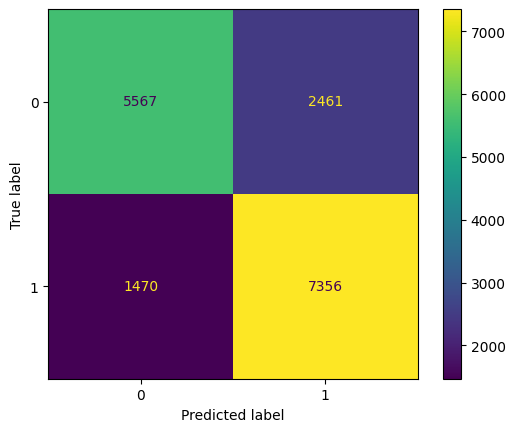

In [24]:
preds = cvlr_gridsearch.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

cm = confusion_matrix(y_test, preds)

disp =ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=cvlr_gridsearch.best_estimator_.classes_)
disp.plot()

sensitivity, specificity, precision, accuracy = calculate_metrics(cm)

print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)
print("Precision:", precision)
print("Accuracy:", accuracy)

The model demonstrates training (86.6%) and test (76.7%) scores, highlighting slight overfitting. It effectively identifies true positives (sensitivity 83.3%) but needs improvement in recognizing true negatives (specificity 69.3%). With precision at 74.9% and accuracy at 76.7%, the model is capable but could be enhanced in specificity and precision. This model does not show any improvement in the test score against its counterpart without hypertuning. 

### 3. Evaluation for Selected Model

#### 3.1 Model selection   

**Model selection:**    
Countvectorizer and Multinomial Naive Bayes model is selected since we are selecting model with the highest accuracy. We are unable to select the model that uses TF-IDF vectorizer as the discrepency between test score and train score is too huge. This indicates strongly that the model will perform badly on test or unseen data. This is especially important in our case of evaluating reviews on app store.  

Multinomial Naives Bayes model is also preferred due to its lower computational complexity. 

Fit parameters in Pipeline and fit our selected model for further evaluation

In [25]:
model = Pipeline([
    ('cvec', CountVectorizer(stop_words = "english", max_df = 0.85, min_df = 2, ngram_range = (1,2))),
    ('nb', MultinomialNB(alpha = 1))
])

model.fit(X_train, y_train)

print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")

train score: 0.8562075990427026
test score: 0.7766108935564258


Save model as a joblib 

In [54]:
dump(model, '../streamlit/pipe_cvnb_gridsearch.joblib')

['../streamlit/pipe_cvnb_gridsearch.joblib']

#### 3.2. Feature importance in prediction

Identify the list of most important features affecting the model's classification outcome. The higher the log probability, the more important is the word used to estimate the outcome of the classification model. 

To predict if comment is related to delivery category

In [27]:
feat_list = []

for i in zip(model.steps[0][1].get_feature_names_out(), model.steps[1][1].feature_log_prob_[1]):
    feat_list.append(i)

feature_importance = pd.DataFrame(feat_list, columns=['Words', 'Log Prob'])
feature_importance.sort_values(by=['Log Prob'], ascending=False, inplace=True)

feature_importance.head(10)

,Words,Log Prob
49689,order,-4.815773
35998,just,-4.825433
72908,tip,-4.942494
39603,like,-4.946659
21245,driver,-4.962437
51980,people,-5.084636
27039,food,-5.094266
43338,make,-5.318771
75420,uber,-5.324084
17847,delivery,-5.377623


We see that the word such as "order", "tip", "food", "customer" and "delivery" ranks highly on the list as expectedly shown in our EDA.  In addition, we see the word "driver" and "uber" ranked highly as well and these words might not necessaarily translate to content related to delivery in the Southeast Asia context (the area where grab operates in).

To predict if comment is related to ride hailing category

In [28]:
feat_list = []

for i in zip(model.steps[0][1].get_feature_names_out(), model.steps[1][1].feature_log_prob_[0]):
    feat_list.append(i)

feature_importance = pd.DataFrame(feat_list, columns=['Words', 'Log Prob'])
feature_importance.sort_values(by=['Log Prob'], ascending=False, inplace=True)

feature_importance.head(10)

,Words,Log Prob
21245,driver,-4.196787
75420,uber,-4.431355
35998,just,-4.880505
60533,ride,-5.033980
39603,like,-5.052302
62612,say,-5.223740
51980,people,-5.231891
10058,car,-5.235840
72234,time,-5.293141
43338,make,-5.329234


We see that the word such as "driver", "uber", "ride", "car" ranks highly on the list as expectedly shown in our EDA.

#### 3.3. Probablilty Distribution of Prediction

We create a dataframe of predicted probabilities, actual classification and predicted classifications to help us evaluate our model. 

In [29]:

pred_proba = [i[1] for i in model.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,'pred_probs':pred_proba})
pred_df["predicted_results"] = pred_df["pred_probs"].map(lambda x: 1 if x >= 0.5 else 0)

# Define function to bin predictions based on confidence on estimation. Delivery related comments predicted with a probability (of class 1) more than 0.85 will be classified as high
# Ride hailing comments predicted with probability (of class 1) less than 0.15 will be classified as high

def split_into_bins(row):
    if (row["predicted_results"] == 1) and (row["pred_probs"] >= 0.85):
        return "high"
    elif (row["predicted_results"] == 0) and (row["pred_probs"] <= 0.15):
        return "high"
    else:
        return "others"

pred_df["bin"] = pred_df.apply(split_into_bins,axis =1)

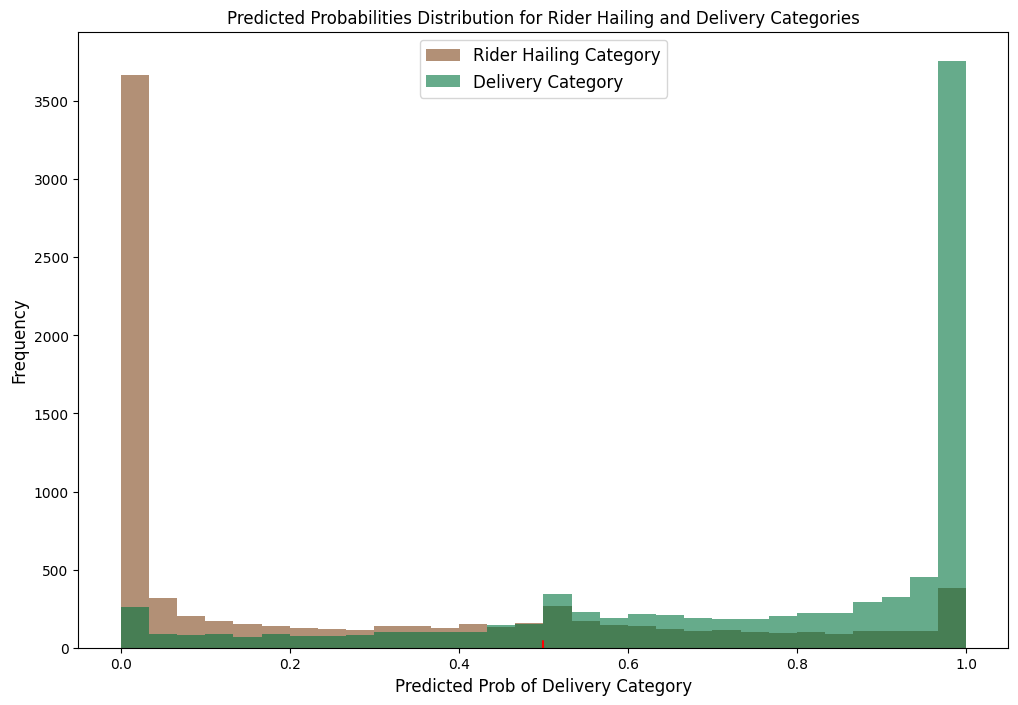

In [30]:
# define colours

grab_green = "#00B14F"
grab_light_green = "#E0FFED"
grab_dark_green = "#00733E"
grab_brown = "#80461B"

# plot probablity distribution graph for estimation of class 1 

plt.figure(figsize = (12,8))
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=30,
         color= grab_brown,
         alpha = 0.6,
         label='Rider Hailing Category')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=30,
         color= grab_dark_green,
         alpha = 0.6,
         label='Delivery Category')
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')
plt.title('Predicted Probabilities Distribution for Rider Hailing and Delivery Categories', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Predicted Prob of Delivery Category', fontsize=12)
plt.legend(fontsize=12)

We see majority of the predictions are done with high confidence. Thus, the two peaks on the both ends. However, we also see a small hump in the middle of the histogram and this can be due to several overlapping terms that are used interchangably between the two service types such as "driver". We will do further analysis below to uncover what can be the reason for low confidence prediction as well as mis-classified comments with high confidence of prediction. 

We plot the below graph for the presentation as well as a simpler view of the above. 

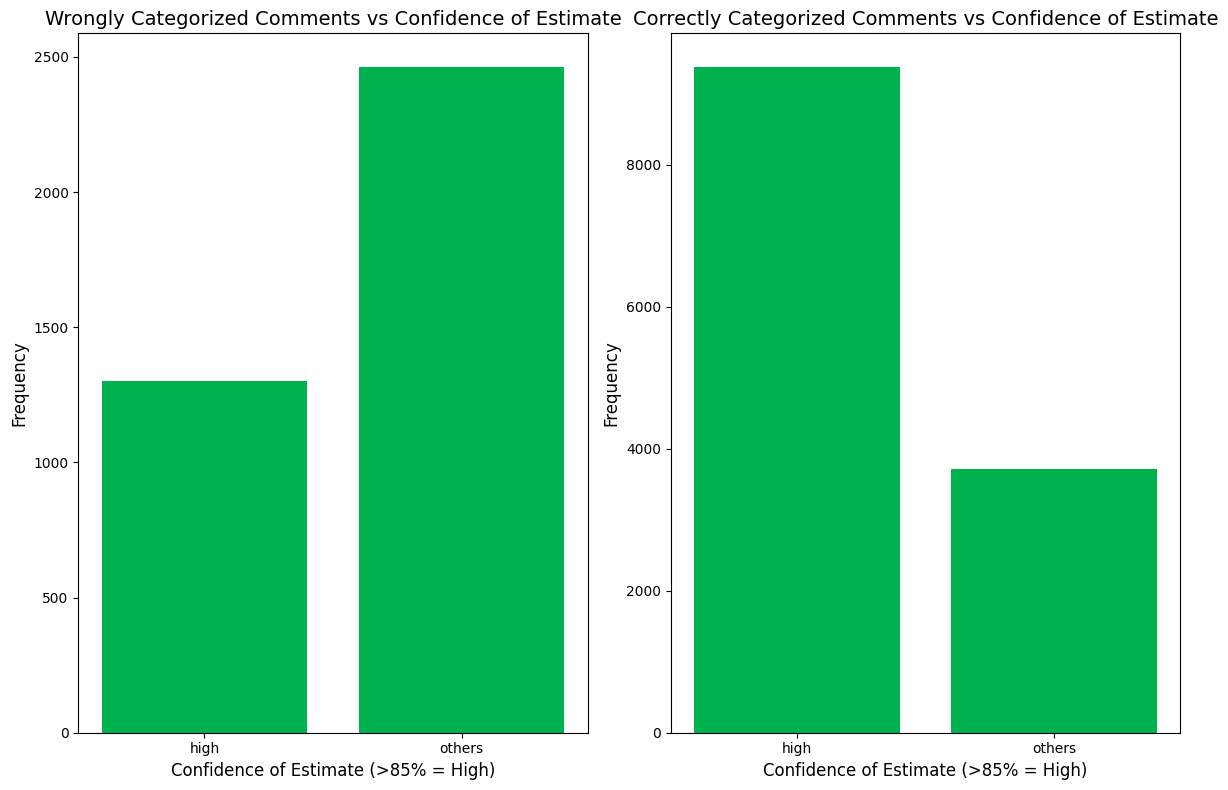

In [31]:

# Plot for wrongly classified results
wrongly_classified_results = pred_df[pred_df["true_values"] != pred_df["predicted_results"]]
wrong_frequency_distribution = wrongly_classified_results['bin'].value_counts()
wrong_frequency_distribution = wrong_frequency_distribution.sort_index()

# Plot for correctly classified results
correct_classified_results = pred_df[pred_df["true_values"] == pred_df["predicted_results"]]
correct_frequency_distribution = correct_classified_results['bin'].value_counts()
correct_frequency_distribution = correct_frequency_distribution.sort_index()

plt.figure(figsize=(12, 8)) 

# Plot 1: Wrongly Classified Results
plt.subplot(1, 2, 1) 
plt.bar(wrong_frequency_distribution.index, wrong_frequency_distribution.values, color=grab_green)
plt.title('Wrongly Categorized Comments vs Confidence of Estimate', fontsize=14)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Confidence of Estimate (>85% = High)', fontsize=12)

# Plot 2: Correctly Classified Results
plt.subplot(1, 2, 2) 
plt.bar(correct_frequency_distribution.index, correct_frequency_distribution.values, color=grab_green)
plt.title('Correctly Categorized Comments vs Confidence of Estimate', fontsize=14)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Confidence of Estimate (>85% = High)', fontsize=12)

plt.tight_layout() 
plt.show()

It is assuring to see that we estimate most of the correctly categorized comments with relatively high confidence (> 85%). We will investigate in the following sections:  
- comments estimated with low level of confidence
- wrongly categorized comments but yet with a high level of confidence. 

#### 3.4. Evaluate comments with low confidence of prediction (between 0.4 and 0.6)

For this section we look at comments that were estimated with low level of confidence. We aim to understand what can be causing this and evaluate if it will adversely impact our use case. 

In [32]:
prob_estimate = model.predict_proba(X_test)
prediction_review = X_test.copy()
prediction_review = pd.DataFrame(prediction_review)
prediction_review["results_class0"] = prob_estimate[:,0]
prediction_review["results_class1"] = prob_estimate[:,1]
prediction_review["actual"] = y_test
unconfident_estimates = prediction_review[(prediction_review["results_class0"] <= 0.6) & (prediction_review["results_class0"] >= 0.4) ]

<Axes: >

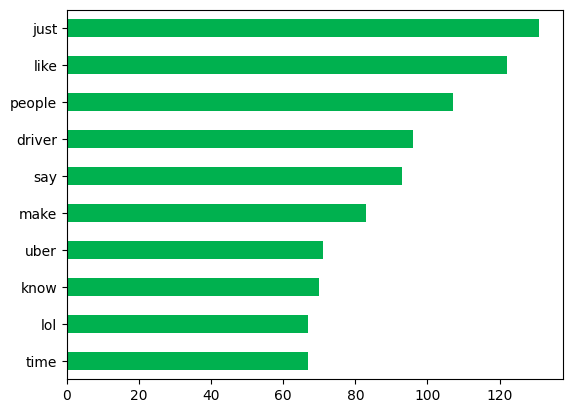

In [33]:
cvec_pe = CountVectorizer(stop_words = "english", max_features = 50)
cvec_pe.fit(unconfident_estimates["body"])
lemmatize_pe_text_transformed = cvec_pe.transform(unconfident_estimates["body"])

pe_df = pd.DataFrame(lemmatize_pe_text_transformed.todense(), 
                          columns=cvec_pe.get_feature_names_out())
pe_df.sum().sort_values(ascending=True).tail(10).plot(kind='barh', color = grab_green)

We see the presence of words such as "driver" and "uber" that we see are high in ranking in both service type from our Exploratory Data Analysis. We acknowledge this and it will be important to know that our classifier might also face similar issues since "Grab" and "Grabfood" might also be used in similar context in Delivery service type. 

In [34]:
unconfident_estimates.head(10)

,body,results_class0,results_class1,actual
57475,"haha , they try take a look at my phone too… s...",0.575211,0.424789,1
55831,r/didntask,0.476354,0.523646,1
61731,is that why nobody wear pant anymore ?,0.497539,0.502461,1
13277,lol no it do n't ! deductible be a thing you f...,0.498639,0.501361,0
7357,2019 be $ 2.19,0.534541,0.465459,0
37534,"call support , report you don ’ t feel safe ! ...",0.448059,0.551941,1
56476,you go for maximum clickbait without give the ...,0.447776,0.552224,1
43281,it say 1 of 2 .,0.518032,0.481968,1
27202,glad you could get that off your chest 😂,0.595270,0.404730,0
25777,huh ?,0.442788,0.557212,0


In addition, we also see that those comments with poor estimation confidence can also be due to comments that cannot be attributed to both service types. These comments will hold no value for our use case regardless of which categories they are categorized under. Example from the above would be"huh?" and "2019 be $2.19"

#### 3.5. Evaluate comments with mis-classification but high confidence (above 0.85)

In this section, we look at comments that are mis-classified but with high confidence. We define them to be above 0.85 in this case. 

Looking at delivery comments wrongly classified as ride hailing. We define a dataframe with only delivery comments wrongly classified with high confidence for evaluation.  

In [35]:
delivery_wrongly_classified = prediction_review[(prediction_review["actual"] == 1) & (prediction_review["results_class0"] >= 0.85) ]

In [36]:
for content in delivery_wrongly_classified["body"].head(20):
    print(content)

need rep who speaks and understands english . and stop reading those damn script ! need rep who can think for themselves and stop be stupid podcasters . do n't they know they can be replace by talkman .
dispute it with your card , uber do n't care .
never let your car get keyed , so you like suck off cop . but dislike the action that come with it ? aweee boooo hoooo wahhhhh “ police they keyed my cawr ” !
that feel like it shouldn ’ t happen though , they should be able to auto-detect that sort of thing . i have a car accident that wasn ’ t my fault on my record from 2 1/2 year ago that auto-flagged and prevents me from do rideshares but they still let me do ubereats . it ’ s the only thing on my entire background check too . a dui should have auto-flagged if a no-fault car accident do .
that ’ s beg and i strongly dislike that . they accepted the job know they might have to wait or they cancel and move on and let someone else get it for you .
lol drive uber doesn ’ t mean you ’ re dum

Excluding irrelevant comments, our analysis revealed that certain comments inaccurately labeled as "ride-hailing" in our test dataset genuinely belong to ride-hailing discussions, albeit posted within the UberEats subreddit. This distinction made by our model is noteworthy. For instance, one comment humorously notes: "lol I have a rider like this. I wouldn't take him & his dog to his destination," illustrating the model's capability to correctly identify ride-hailing related content in an unexpected context."

Looking at ride hailing comments wrongly classified as delivery. We define a dataframe with only ride hailing comments wrongly classified with high confidence for evaluation.  

In [37]:
ride_hailing_wrongly_classified = prediction_review[(prediction_review["actual"] == 0) & (prediction_review["results_class1"] >= 0.99) ]

In [38]:
for content in ride_hailing_wrongly_classified["body"].head(20): 
    print(content)

so if your finger slip and you accidentally add a 0 , tip $ 50.00 instead of $ 5.00 you 're just shit out of luck ? 😬😬
then take it up with the government , not the people order food .
have you try any of the fine din food delivery apps ?
most be like $ 3 in my area so i turn off delivery and only do ride . i ai n't spending 40+ minute to go get food and deliver it for $ 3 dollar .
my response would be , nice of u to still have a family my kid get kill outside the restaurant i work at , then my wife die of a heart attack last month , i have n't left the house since and now i 'm in debt a i just ca n't leave the house it re eminds me of them to much . please bring me more food and of your scrap would help i 'm 30000 in debt and about to be evict . .end response .... or yeah just cancel then and get a hourly job your clearly not cut out to be a contractor . ask your bos for money i just paid 15 $ in fee
i ran into this issue a couple year ago , end up wag a twitter battle against uber , 

Mirroring our prior analysis and setting aside irrelevant comments, we observed that certain comments in our test set, initially misclassified as "delivery," indeed pertain to delivery topics within the Uber subreddit. It's beneficial that our model could discern this. An illustrative comment fitting this category humorously states: "As far as I know, there are only 2 delivery options: deliver to the door and hand it to me. I guess I have mine set to hide and seek. My bad."

### 4. Putting our classifier into action and conclusion

#### 4.1. Putting our classifier into action

As part of this project, the team has manually seperated the 414 grab reviews on google play store manually into their respective service types. The file is available in our dataset folder named: `grab_review_testset.csv`

We will read the file and perform transformation prior to fitting the model onto our data and assess the performance. 

In [39]:
df_grab = pd.read_csv("../datasets/grab_review_testset.csv")

We need to pre-process our grab review before fitting into our selected model via the below steps:  
1. replace "grabfood" and "grab" with "ubereats" and "uber" respectively for models' evaluation. 
2. lemmatize the content 

In [57]:
# define functions to lemmatize our content

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_sentence(sentence):
    words = word_tokenize(sentence)
    list_lemmatized_words = [(lemmatizer.lemmatize(word, get_wordnet_pos(word))).lower() for word in words]
    return ' '.join(list_lemmatized_words)

# replace "grabfood" and "grab" to their equivalent terms in the model

df_grab["content"] = df_grab["content"].str.lower().str.replace("grabfood", "ubereats", regex=False)
df_grab["content"] = df_grab["content"].str.lower().str.replace("grab food", "ubereats", regex=False)
df_grab["content"] = df_grab["content"].str.lower().str.replace("grab", "uber", regex=False)

# lemmatize the content to fit to model

lemmatizer = WordNetLemmatizer()
lemmatize_grab_text = [lemmatize_sentence(sentence) for sentence in df_grab["content"]]

Define our X and y to fit to model

In [58]:
X_grab = lemmatize_grab_text
y_grab = df_grab["label"]
print(f"test score: {model.score(X_grab, y_grab)}")

test score: 0.8236714975845411


Generate the confusion matrix and evaluation metrics

Sensitivity (True Positive Rate): 0.8104575163398693
Specificity (True Negative Rate): 0.8314176245210728
Precision: 0.7380952380952381
Accuracy: 0.8236714975845411


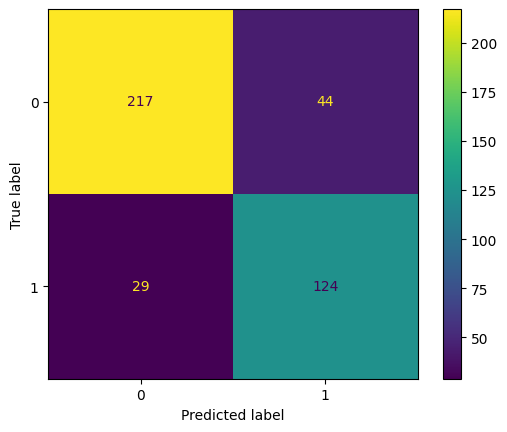

In [59]:
preds = model.predict(X_grab)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_grab, preds).ravel()

cm = confusion_matrix(y_grab, preds)

disp =ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=model.classes_)
disp.plot()

sensitivity, specificity, precision, accuracy = calculate_metrics(cm)

print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)
print("Precision:", precision)
print("Accuracy:", accuracy)


The model exhibits solid accuracy (82.37%) and balances well between sensitivity (81.05%) and specificity (83.14%), indicating effective identification of both positive and negative cases. We will further evaluate our models' wrong predictions to learn on the shortcomings in the following section. 

#### 4.2. Conclusion and Recommendations

After our model evaluation and EDA, we have successful identified a countvectorized multinomial naive bayes model as our selected model with an accuracy score of 77.7% on test data.
We further validate our model for the use case with real app reviews from the google play store and assess the suitability of this model for our use case. We managed to achieve an accuracy score of 82.37% (better than our test score of 77.7%).   
  
The results is promising but we should also recognize that the model is not perfect. The below can help to improve the experience of our end users:
1. Discover better training data that can gives us better prediction. This can be done by scrapping for more localized content such as hardware zone since there are fundamental linguistic differences between countries Uber operate in vs SouthEast Asia.  
  
2. Similar to subreddit, app review comments contains uninformative reviews such as "i like him" which can be filtered out prior to classification. This will also ensure our end users get better quality data for analysis. One of the next steps can be to develop a classifier to identify such cases. 

3. Recommend implementing a classifier capable of detecting not only binary discrete results but also multiple discrete outcomes. This enhanced classifier would not only differentiate between ride-hailing and delivery services but also consider overall app performance. By incorporating this multi-class classification approach, we can provide more comprehensive insights into customer feedback, enabling Grab to address specific issues related to each service while simultaneously improving overall app functionality and user experience. Additionally, deploying advanced natural language processing techniques could further refine the classifier's accuracy and effectiveness in handling diverse customer feedback scenarios.

All in all, even though this model is not perfect, an accuracy score of 77.7% against our initial baseline model that only predicts the majority with an accuracy of 52.4% is a good step towards helping our target audience (the product managers) automate the classification process. 

